# Homework 2

# Code by M. Pak - needed results for HW3 and HW4

In [1]:
# import packages

import psycopg2
import getpass
import numpy as np
import datetime
import time
import pandas as pd
import dateutil.relativedelta as dr

# connect with database
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
conn=psycopg2.connect(user=a, 
                      database=b, 
                      host=c,
                      port=d,
                      password=getpass.getpass('Insert password'))

# check parameters

print(conn.get_dsn_parameters())

User of database: postgres
Name of database: postgres
Host: Localhost
Port: 5432
Insert password········
{'user': 'postgres', 'dbname': 'postgres', 'host': 'Localhost', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


In [2]:
# extract data from bond_description and quotes

query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes_task  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM public.bond_description_task 
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

# read query in python

data = pd.read_sql_query(query, conn) 

# Extract more specified data 
data.drop(['ISINCode'], axis=1)
data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
data = data[~data.CPN.isna()].reset_index(drop = True)
data = data[data.CPN != 0]
data = data[data.CouponPerYear > 0]

# if you had timestamp format in any of extracted fields so change format to date
# in my case it was only buybackdate

# data.BUYBACKDATE = data.BUYBACKDATE.dt.date
data.head()

,CPN,ISIN,BUYBACKDATE,BUYBACKPRICE,ISINCode,FaceValue,HaveOffer,AmortisedMty,CouponPerYear,NumCoupons,EndMtyDate,CouponType,IssuerName
0,41.1400,RU000A0GN9B5,2013-02-21,100.0,RU000A0GN9B5,1000.0,True,False,2,20,2016-02-18,Переменный,Мосэнерго (ТГК-3)
1,30.2918,RU000A0JNGU3,2016-01-06,100.0,RU000A0JNGU3,1000.0,True,False,4,40,2016-07-06,Переменный,Банк ВТБ
2,40.1100,RU000A0JNYN1,None,0.0,RU000A0JNYN1,1000.0,False,False,2,31,2022-06-11,Фиксированный,Москва Правительство
3,40.1100,RU000A0JNYP6,None,0.0,RU000A0JNYP6,1000.0,True,False,2,21,2017-06-14,Фиксированный,Москва Правительство
4,77.2900,RU000A0JNZW9,2009-06-17,100.0,RU000A0JNZW9,1000.0,True,False,2,8,2010-12-15,Переменный,Вагонмаш


In [3]:
# function to count coupon payments

def coupon_count(coup_str):
    full_matrix = pd.DataFrame() # local var
    end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
    a = int(coup_str.CouponPerYear.values[0])
    b = float(coup_str.NumCoupons.values[0])
    types = True
    if coup_str.CPN is not None or coup_str.CPN != 0:
        if coup_str.AmortisedMty.astype(str).values[0] == 'False':
            types = False
            amount = coup_str.CPN.values[0]
            for j in np.linspace((b - 1) / a, 0, b):
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount += coup_str.FaceValue.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                amount = coup_str.CPN.values[0]
        else:
            percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
            index = (b - 1)
            face = coup_str.FaceValue.values[0]
            while index >= 0:
                amount = percent * face
                date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                    date = end_date
                    amount = coup_str.BUYBACKPRICE.values[0]
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                    date = end_date
                    amount = face
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    break
                full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                index -= 1
                face = face * (1 - percent)
    my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                           , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
    full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
    return full_matrix

In [5]:
# full_matrix contains coupon payments for all the emitents
# global var:

full_matrix = pd.DataFrame()

# fill in full_matrix

for i in data.iterrows():
    full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
    
# example
full_matrix.fillna(0).head(20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


,,,2006-08-19,2006-10-06,2007-01-05,2007-02-18,2007-04-06,2007-06-11,2007-06-15,2007-06-16,2007-07-07,2007-08-11,...,2031-03-21,2031-09-20,2032-03-21,2032-09-19,2033-03-21,2033-09-20,2034-03-21,2034-09-20,2035-03-21,2035-09-20
ISIN,Amortisation,Issuer,,,,,,,,,,,,,,,,,,,,,
RU000A0GN9B5,Not Amortised,Мосэнерго (ТГК-3),41.14,0.0000,0.0000,41.14,0.0000,0.00,0.00,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JNGU3,Not Amortised,Банк ВТБ,0.00,30.2918,30.2918,0.00,30.2918,0.00,0.00,0.00,30.2918,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JNYN1,Not Amortised,Москва Правительство,0.00,0.0000,0.0000,0.00,0.0000,40.11,0.00,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JNYP6,Not Amortised,Москва Правительство,0.00,0.0000,0.0000,0.00,0.0000,0.00,40.11,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JNZW9,Not Amortised,Вагонмаш,0.00,0.0000,0.0000,0.00,0.0000,0.00,0.00,77.29,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JP2G4,Not Amortised,Россельхозбанк,0.00,0.0000,0.0000,0.00,0.0000,0.00,0.00,0.00,0.0000,46.12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JPF47,Not Amortised,Россельхозбанк,0.00,0.0000,0.0000,0.00,0.0000,0.00,0.00,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JPK81,Not Amortised,МеждународПромБанк,0.00,0.0000,0.0000,0.00,0.0000,0.00,0.00,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
RU000A0JPMT8,Not Amortised,Россельхозбанк,0.00,0.0000,0.0000,0.00,0.0000,0.00,0.00,0.00,0.0000,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# check
print(full_matrix.values[0].T != 'nan')
print(full_matrix.shape) # table: 500 rows, 2230 columns


True
(500, 2230)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [7]:
# from the given date to the end
import datetime
from datetime import datetime, timedelta, date
def from_date_matrix(issuer_name, date):
    
    spec_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) < date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            spec_payments = pd.concat([spec_payments, data], axis = 1)
    return spec_payments

In [8]:
# example
# insert date in format yyyy-mm-dd
from_date_matrix('Банк ВТБ','2010-01-01')


,,2010-01-05,2010-04-06,2010-07-06,2010-10-06,2011-01-05,2011-04-06,2011-07-07,2011-10-06,2012-01-05,2012-04-06,...,2016-01-05,2016-01-06,2016-01-19,2016-02-16,2016-03-24,2016-03-30,2016-06-23,2016-06-28,2016-06-29,2016-07-08
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JNGU3,Not Amortised,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,30.2918,...,30.2918,100.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JTK20,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,1020.32,0.0,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JTN01,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,1019.7,0.00,0.00,0.00,0.0,0.00,0.0
RU000A0JU773,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,35.28,0.00,0.0,35.28,100.0
RU000A0JUQE1,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,23.81,0.00,23.81,100.0,0.00,0.0
RU000A0JV3Q3,Not Amortised,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0


In [9]:
# payments on specified date
def on_spec_date(issuer_name, date):
    on_spec_date_payments = pd.DataFrame()
    for i in range(0,len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name),\
        level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365 / 12 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how='all').fillna(0).columns[i].split('-')[2])
        if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365 / 12 + int(date.split('-')[2]) == date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            on_spec_date_payments = pd.concat([on_spec_date_payments, data], axis = 1)
    return on_spec_date_payments

In [10]:
on_spec_date('Банк ВТБ','2016-02-16')

,,2016-02-16
ISIN,Amortisation,
RU000A0JNGU3,Not Amortised,0.0
RU000A0JTK20,Not Amortised,0.0
RU000A0JTN01,Not Amortised,1019.7
RU000A0JU773,Not Amortised,0.0
RU000A0JUQE1,Not Amortised,0.0
RU000A0JV3Q3,Not Amortised,0.0


In [11]:
# from the beginning date to today

import datetime
acctual_date = datetime.datetime.now().strftime("%Y-%m-%d")

def from_date_to_today(issuer_name):
    from_date_to_today_payments = pd.DataFrame()
    for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
        date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
        how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + \
        int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 \
        + int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
        if int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[0]) * 365 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[1]) * 365/12 + \
        int(datetime.datetime.now().strftime("%Y-%m-%d").split('-')[2]) > date_size:
            data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
            from_date_to_today_payments = pd.concat([from_date_to_today_payments, data], axis = 1)
    return from_date_to_today_payments

In [12]:
from_date_to_today('Россельхозбанк')

,,2007-08-11,2008-02-10,2008-03-28,2008-08-10,2008-09-27,2008-12-04,2009-02-09,2009-03-28,2009-05-28,2009-06-05,...,2019-04-01,2019-05-01,2019-06-28,2019-07-01,2019-07-31,2019-09-28,2019-10-01,2019-10-04,2019-10-07,2019-10-30
ISIN,Amortisation,,,,,,,,,,,,,,,,,,,,,
RU000A0JP2G4,Not Amortised,46.12,46.12,0.0000,46.12,0.0000,0.00,46.12,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPF47,Not Amortised,0.00,0.00,61.5808,0.00,61.5808,0.00,0.00,61.5808,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPMT8,Not Amortised,0.00,0.00,0.0000,59.34,0.0000,0.00,59.34,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JPTE5,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,34.41,0.00,0.0000,0.00,34.41,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQ1H3,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,67.32,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQK64,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQK72,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQS09,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0
RU000A0JQS74,Not Amortised,0.00,0.00,0.0000,0.00,0.0000,0.00,0.00,0.0000,0.00,0.00,...,0.000,0.0,0.000,0.000,0.0,0.000,0.000,0.0,0.0,0.0


In [13]:
# BONUS: from the given date to the end

def crazy(issuer_name, date, db_login, from_date_matrix):

    conn = psycopg2.connect(user = db_login['user'],
                            database = db_login['database'], 
                            host = db_login['host'], 
                            port = db_login['port'], 
                            password = getpass.getpass('Insert password: '))

    query = """SELECT *
            FROM (SELECT MAX("CPN") AS "CPN", "ISIN", max("BUYBACKDATE") AS "BUYBACKDATE",
                  max("BUYBACKPRICE") AS "BUYBACKPRICE"
                  FROM public.quotes_task  
                  GROUP BY "ISIN") AS a
            INNER JOIN(SELECT "ISINCode", "FaceValue", "HaveOffer", "AmortisedMty", 
                       "CouponPerYear", "NumCoupons", "EndMtyDate", "CouponType", "IssuerName"
                       FROM public.bond_description_task
                       WHERE "Status"!='Погашен') AS b
            ON a."ISIN" = b."ISINCode";"""

    # read query in python

    data = pd.read_sql_query(query, conn) 

    # Extract more specified data 
    data.drop(['ISINCode'], axis=1)
    data.BUYBACKPRICE = data.BUYBACKPRICE.fillna(0)
    data = data[~data.CPN.isna()].reset_index(drop = True)
    data = data[data.CPN != 0]
    data = data[data.CouponPerYear > 0]

    # if you had timestamp format in any of extracted fields so change format to date
    # in my case it was only buybackdate

#     data.BUYBACKDATE = data.BUYBACKDATE.dt.date
    
    def coupon_count(coup_str):
        full_matrix = pd.DataFrame() # local var
        end_date = coup_str.BUYBACKDATE.values[0] if coup_str.BUYBACKDATE.values[0] is not None else coup_str.EndMtyDate.values[0]
        a = int(coup_str.CouponPerYear.values[0])
        b = float(coup_str.NumCoupons.values[0])
        types = True
        if coup_str.CPN is not None or coup_str.CPN != 0:
            if coup_str.AmortisedMty.astype(str).values[0] == 'False':
                types = False
                amount = coup_str.CPN.values[0]
                for j in np.linspace((b - 1) / a, 0, b):
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25 * j))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount += coup_str.FaceValue.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    amount = coup_str.CPN.values[0]
            else:
                percent = float(coup_str.CPN.values[0]) / float(coup_str.FaceValue.values[0])
                index = (b - 1)
                face = coup_str.FaceValue.values[0]
                while index >= 0:
                    amount = percent * face
                    date = coup_str.EndMtyDate.values[0] - dr.relativedelta(days = round(365.25*index/a))
                    if date >= end_date and coup_str.EndMtyDate.values[0] != end_date :
                        date = end_date
                        amount = coup_str.BUYBACKPRICE.values[0]
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    elif date >= end_date and coup_str.EndMtyDate.values[0] == end_date:
                        date = end_date
                        amount = face
                        full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                        break
                    full_matrix = pd.concat([full_matrix, pd.DataFrame({date.strftime("%Y-%m-%d"): [amount]})], axis = 1)
                    index -= 1
                    face = face * (1 - percent)
        my_index = pd.MultiIndex.from_tuples([(coup_str.ISIN.values[0], 'Amortised' if types else 'Not Amortised'
                                               , coup_str.IssuerName.values[0] )], names=['ISIN', 'Amortisation', 'Issuer'])
        full_matrix = pd.DataFrame(full_matrix.values, index = my_index, columns = full_matrix.columns)
        return full_matrix
    
    full_matrix = pd.DataFrame()

    # fill in full_matrix

    for i in data.iterrows():
        full_matrix = pd.concat([full_matrix, coupon_count(pd.DataFrame(i[1]).T)], sort = True)
        full_matrix = full_matrix.fillna(0)
    
    import datetime
    def from_date_matrix(issuer_name, date):
        spec_payments = pd.DataFrame()
        for i in range(0, len(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns)):
            date_size = int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, \
            how = 'all').fillna(0).columns[i].split('-')[0]) * 365 + int(full_matrix.xs(str(issuer_name), \
            level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[1]) * 365/12 + \
            int(full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).columns[i].split('-')[2])
            if int(date.split('-')[0]) * 365 + int(date.split('-')[1]) * 365/12 + int(date.split('-')[2]) < date_size:
                data = full_matrix.xs(str(issuer_name), level = 2).dropna(axis = 1, how = 'all').fillna(0).iloc[:, i:i+1]
                spec_payments = pd.concat([spec_payments, data], axis = 1)
        return spec_payments
    
    results = {'ISSUER': issuer_name, 'DATE': date, 'MATRIX_OF_PAYMENTS': from_date_matrix(issuer_name, date)}
    return results

In [38]:
a = input('User of database: ' )
b = input('Name of database: ' )
c = input('Host: ' )
d = input('Port: ' )
e = input('Input issuer name: ')
f = input('Input date: ')
login = {'user': a, 'database': b, 'host': c, 'port': d}
x = crazy(e, f, login, from_date_matrix)
print(x['ISSUER'], x['DATE'])
x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]

User of database: postgres
Name of database: postgres
Host: Localhost
Port: 5432
Input issuer name: Мечел
Input date: 2015-06-20
Insert password: ········


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


Мечел 2015-06-20


,,2015-07-22,2015-08-11,2015-08-26,2015-10-21,2015-11-26,2015-12-01,2016-01-20,2016-02-10,2016-02-25,2016-03-01,2016-04-21,2016-05-27,2016-06-01,2016-06-02,2016-06-07,2016-07-21,2016-08-10,2016-08-16
ISIN,Amortisation,,,,,,,,,,,,,,,,,,
RU000A0JQ8V9,Not Amortised,47.37,0.00,0.000000,47.37,0.0000,0.0000,47.37,0.00,0.000000,0.0,47.37,0.0000,0.0000,0.0,0.0,1047.37,0.00,0.0
RU000A0JR0J0,Amortised,0.00,0.00,37.154679,0.00,0.0000,0.0000,0.00,0.00,34.375714,100.0,0.00,0.0000,0.0000,0.0,0.0,0.00,0.00,0.0
RU000A0JR0K8,Amortised,0.00,0.00,37.154679,0.00,0.0000,0.0000,0.00,0.00,34.375714,100.0,0.00,0.0000,0.0000,0.0,0.0,0.00,0.00,0.0
RU000A0JR8L9,Not Amortised,0.00,64.82,0.000000,0.00,0.0000,0.0000,0.00,64.82,0.000000,0.0,0.00,0.0000,0.0000,0.0,0.0,0.00,64.82,100.0
RU000A0JR8P0,Not Amortised,0.00,64.82,0.000000,0.00,0.0000,0.0000,0.00,64.82,0.000000,0.0,0.00,0.0000,0.0000,0.0,0.0,0.00,64.82,100.0
RU000A0JRJS2,Not Amortised,0.00,0.00,0.000000,0.00,41.8849,0.0000,0.00,0.00,0.000000,0.0,0.00,41.8849,0.0000,100.0,0.0,0.00,0.00,0.0
RU000A0JRJT0,Not Amortised,0.00,0.00,0.000000,0.00,41.8849,0.0000,0.00,0.00,0.000000,0.0,0.00,41.8849,0.0000,100.0,0.0,0.00,0.00,0.0
RU000A0JRJY0,Not Amortised,0.00,0.00,0.000000,0.00,0.0000,41.8849,0.00,0.00,0.000000,0.0,0.00,0.0000,41.8849,0.0,100.0,0.00,0.00,0.0


# Homework 3

In [39]:
# ПУНКТ 1: В первую очередь необходимо сгруппировать результаты по признаку амортизации
table1 = x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)]
grouped_results = x['MATRIX_OF_PAYMENTS'].loc[:, (x['MATRIX_OF_PAYMENTS'] != 0).any(axis = 0)].groupby('Amortisation').sum()
grouped_results

,2015-07-22,2015-08-11,2015-08-26,2015-10-21,2015-11-26,2015-12-01,2016-01-20,2016-02-10,2016-02-25,2016-03-01,2016-04-21,2016-05-27,2016-06-01,2016-06-02,2016-06-07,2016-07-21,2016-08-10,2016-08-16
Amortisation,,,,,,,,,,,,,,,,,,
Amortised,0.00,0.00,74.309358,0.00,0.0000,0.0000,0.00,0.00,68.751427,200.0,0.00,0.0000,0.0000,0.0,0.0,0.00,0.00,0.0
Not Amortised,47.37,129.64,0.000000,47.37,83.7698,41.8849,47.37,129.64,0.000000,0.0,47.37,83.7698,41.8849,200.0,100.0,1047.37,129.64,200.0


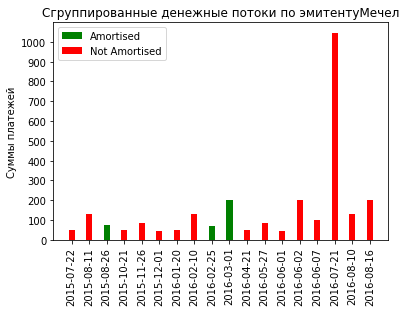

In [40]:
# ПУНКТ 2: Построим stacked bar график по полученной таблице
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Обозначим оси и значения
x_axis = grouped_results.columns
val1 = grouped_results.iloc[0]
val2 = grouped_results.iloc[1]

width = 0.35       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(x_axis, val1, width, color = 'g')
p2 = plt.bar(x_axis, val2, width,
             bottom=val1, color = 'r')

plt.ylabel('Суммы платежей')
plt.title('Сгруппированные денежные потоки по эмитенту ' + str(e))
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, 1100, 100))
plt.legend((p1[0], p2[0]), ('Amortised', 'Not Amortised'))

picture1 = plt.show(p1, p2)
plt.show()

In [44]:
# ПУНКТ 3: Дюрация и scattered plot - не удалось :(

# Homework 4

In [41]:
# 4 ДЗ - таблица для сохранения - будем сохранять таблицу, полученную по итогам ДЗ 2
table_name = input ('Придумайте название для сохраняемой таблицы: ')
name_len = len(table_name)

# проверка на пустую строку
if name_len == 0:
    table_name = 'Таблица платежей по облигациям эмитента ' + str(e)
else:
    table_name = table_name
    
table_path = input ('Укажите путь для сохранения таблицы: ')
path_len = len(table_path)
if path_len == 0:
    table_path = 'C:\\Users\\Public'
else:
    table_path = table_path
    
table1.to_csv(table_path + '\\' + table_name + '.csv', index = True)

Придумайте название для сохраняемой таблицы: 
Укажите путь для сохранения таблицы: 


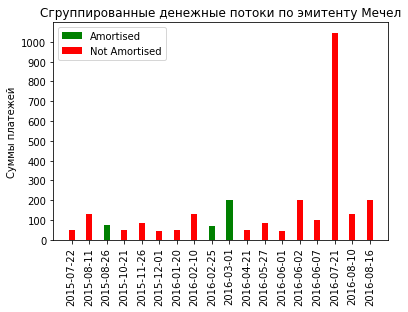

Придумайте название для рисунка: 
Укажите путь для сохранения графика: 


<Figure size 432x288 with 0 Axes>

In [43]:
# Создаем тот же рисунок "на лету"
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Обозначим оси и значения
x_axis = grouped_results.columns
val1 = grouped_results.iloc[0]
val2 = grouped_results.iloc[1]

width = 0.35       # the width of the bars: can also be len(x) sequence
p1 = plt.bar(x_axis, val1, width, color = 'g')
p2 = plt.bar(x_axis, val2, width,
             bottom=val1, color = 'r')

plt.ylabel('Суммы платежей')
plt.title('Сгруппированные денежные потоки по эмитенту ' + str(e))
plt.xticks(rotation = 90)
plt.yticks(np.arange(0, 1100, 100))
plt.legend((p1[0], p2[0]), ('Amortised', 'Not Amortised'))

picture1 = plt.show(p1, p2)
plt.show()


# Сохранение рисунка
pic_name = input ('Придумайте название для рисунка: ')
pic_len = len(pic_name)

# проверка на пустую строку
if pic_len == 0:
    pic_name = 'График денежных потоков облигациям эмитента ' + str(e)
else:
    pic_name = pic_name
    
pic_path = input ('Укажите путь для сохранения графика: ')
pic_path_len = len(pic_path)
if pic_path_len == 0:
    pic_path = 'C:\\Users\\Public'
else:
    pic_path = pic_path
    
plt.savefig(pic_path + '\\' + pic_name + '.png')

In [ ]:
# ДЗ 4 - РЕПОРТИНГ - для начала необходимо подключить некоторые библиотеки, инструкцию можно найти здесь: 
# https://github.com/IT4finance/seminars/blob/master/seminar_13_dec_report_update.ipynb


# Собираем автоматический отчет в виде pdf

from __future__ import print_function
from jinja2 import Environment, FileSystemLoader
from weasyprint import HTML, Document
import os

env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("myreport.html") # Шаблон отчета должен находиться в рабочей директории
template_vars = {"title": "Отчет составлен Мельником Антоном Вячеславовичем",
                "INTRO": "Отчет о денежных потоках по облигациям эмитента " + str(e),
                 "TABLE_DESC": "Таблица денежных потоков по облигациям эмитента " +str(e) + "на дату" + str(f), 
                 "TABLE": table1.to_html(), 
                 "IMAGE_DESC": "На графике изображены денежные потоки по одной из облагий эмитента " + str(e), 
                 "IMAGE": os.path.realpath(pic_path + '\\' + pic_name + '.png')
                }
# os.path.realpath - путь к файлу относительно рабочей папки. Код выше подразумевает, что картинка хранится в рабочей папке.
# Собираем и печатаем репорт
html_out = template.render(template_vars, presentational_hints=True)
HTML(string=html_out).write_pdf('my_report.pdf', presentational_hints=True)